Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Model Evaluation Results:
Accuracy: 0.9570

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.92      0.87      0.89       111
           2       0.96      0.97      0.97       294
           3       0.88      0.89      0.89       186

    accuracy                           0.96      1000
   macro avg       0.94      0.93      0.94      1000
weighted avg       0.96      0.96      0.96      1000


Cross-validation scores: [0.945   0.9575  0.96    0.9675  0.94625]
Mean CV Score: 0.9553


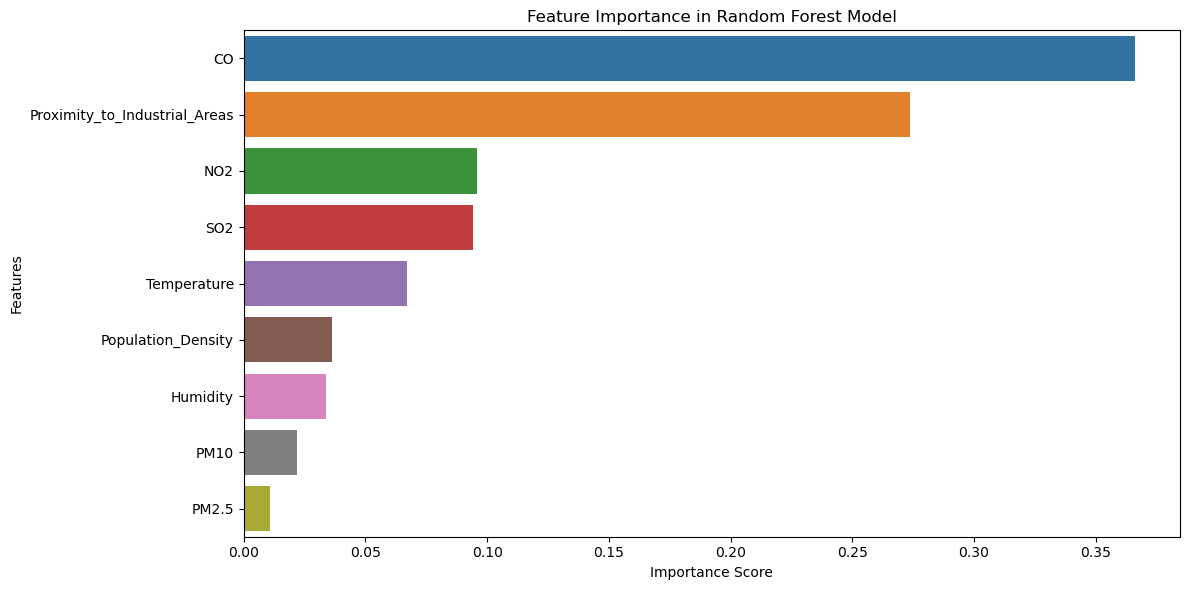

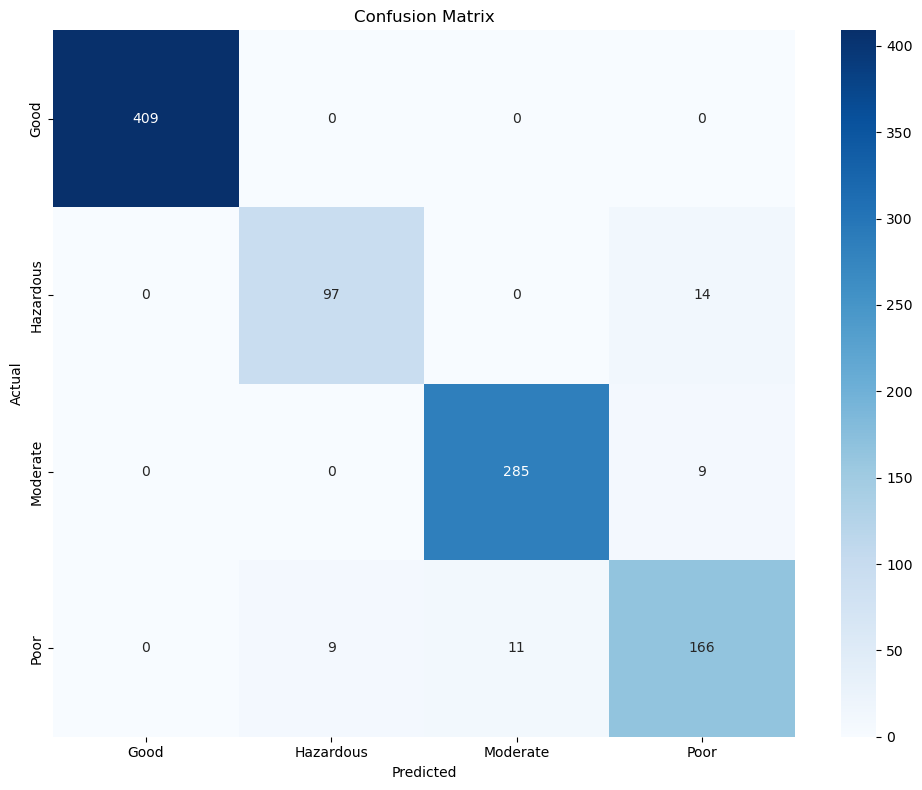

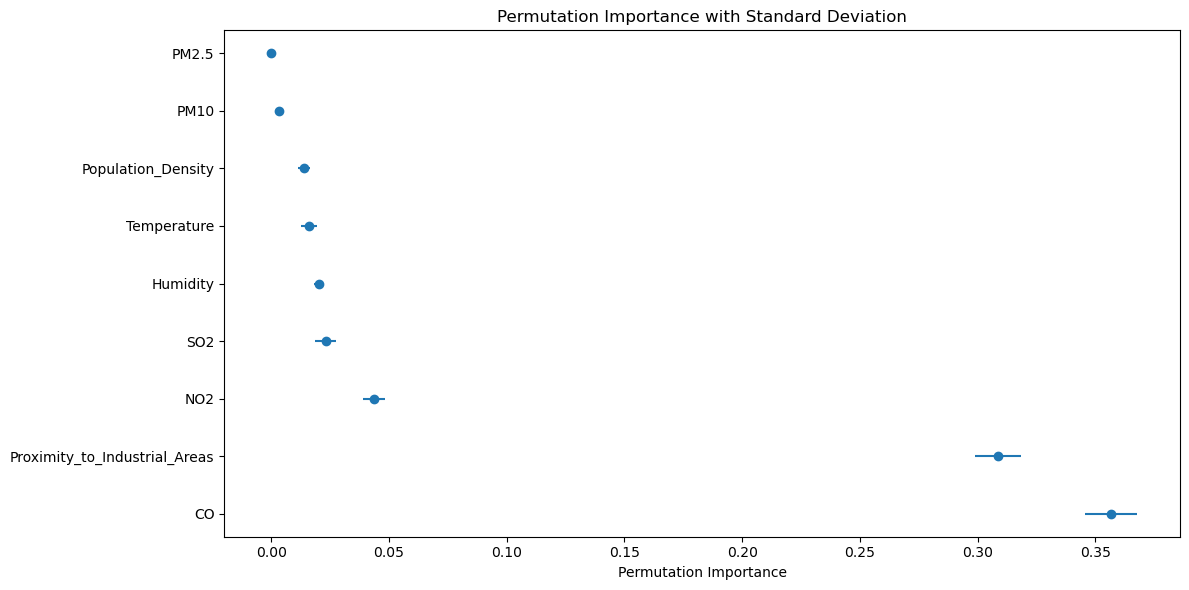

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

class RandomForestAnalysis:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.model = None
        self.feature_importance = None
        
    def load_and_preprocess_data(self, data_path):
        # Load data
        self.df = pd.read_csv(data_path)
        
        # Separate features and target
        X = self.df.drop('Air Quality', axis=1)
        y = self.df['Air Quality']
        
        # Encode target variable
        y = self.label_encoder.fit_transform(y)
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=self.random_state
        )
        
        return X_scaled, y
    
    def perform_grid_search(self):
        # Define parameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        # Initialize base model
        base_model = RandomForestClassifier(random_state=self.random_state)
        
        # Perform grid search
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='accuracy',
            verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        self.model = grid_search.best_estimator_
        
        return grid_search.best_params_
    
    def train_model(self):
        if self.model is None:
            self.model = RandomForestClassifier(
                n_estimators=200,
                max_depth=20,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state
            )
        
        # Train the model
        self.model.fit(self.X_train, self.y_train)
        
        # Calculate feature importance
        self.feature_importance = pd.DataFrame({
            'feature': self.df.drop('Air Quality', axis=1).columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
    
    def evaluate_model(self):
        # Make predictions
        y_pred = self.model.predict(self.X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        class_report = classification_report(self.y_test, y_pred)
        
        # Cross-validation scores
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        
        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'cv_scores': cv_scores
        }
    
    def plot_feature_importance(self):
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=self.feature_importance,
            x='importance',
            y='feature'
        )
        plt.title('Feature Importance in Random Forest Model')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        return plt
    
    def plot_confusion_matrix(self, confusion_mat):
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            confusion_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.label_encoder.classes_,
            yticklabels=self.label_encoder.classes_
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        return plt
    
    def calculate_permutation_importance(self):
        # Calculate permutation importance
        perm_importance = permutation_importance(
            self.model,
            self.X_test,
            self.y_test,
            n_repeats=10,
            random_state=self.random_state
        )
        
        # Create DataFrame with permutation importance results
        perm_imp_df = pd.DataFrame({
            'feature': self.df.drop('Air Quality', axis=1).columns,
            'importance_mean': perm_importance.importances_mean,
            'importance_std': perm_importance.importances_std
        }).sort_values('importance_mean', ascending=False)
        
        return perm_imp_df
    
    def plot_permutation_importance(self, perm_imp_df):
        plt.figure(figsize=(12, 6))
        plt.errorbar(
            x=perm_imp_df['importance_mean'],
            y=range(len(perm_imp_df)),
            xerr=perm_imp_df['importance_std'],
            fmt='o'
        )
        plt.yticks(range(len(perm_imp_df)), perm_imp_df['feature'])
        plt.xlabel('Permutation Importance')
        plt.title('Permutation Importance with Standard Deviation')
        plt.tight_layout()
        return plt

# Usage example:
def main():
    # Initialize the analysis
    rf_analysis = AdvancedRandomForestAnalysis()
    
    # Load and preprocess data
    X, y = rf_analysis.load_and_preprocess_data('updated_pollution_dataset.csv')
    
    # Perform grid search for optimal parameters
    best_params = rf_analysis.perform_grid_search()
    print("Best parameters:", best_params)
    
    # Train the model
    rf_analysis.train_model()
    
    # Evaluate the model
    evaluation_results = rf_analysis.evaluate_model()
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {evaluation_results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(evaluation_results['classification_report'])
    print("\nCross-validation scores:", evaluation_results['cv_scores'])
    print(f"Mean CV Score: {evaluation_results['cv_scores'].mean():.4f}")
    
    # Generate and save plots
    rf_analysis.plot_feature_importance().savefig('feature_importance.png')
    rf_analysis.plot_confusion_matrix(evaluation_results['confusion_matrix']).savefig('confusion_matrix.png')
    
    # Calculate and plot permutation importance
    perm_imp_df = rf_analysis.calculate_permutation_importance()
    rf_analysis.plot_permutation_importance(perm_imp_df).savefig('permutation_importance.png')

if __name__ == "__main__":
    main()